In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pylab as plt
import math
import seaborn as sbn
%matplotlib inline

## 1. Data Preparation

#### Essential Workers Population Ratio

In [26]:
# dataframe
gdf_ew = gpd.read_file('../../survey_block/data/Taxi_Population/Taxi_Population.shp')

In [27]:
# delete old trip columns
gdf_ew.drop(['trips', 'trips_ly', 'yoy'], axis=1, inplace=True)

In [31]:
# calculate the estimatd essential workers population ratio
gdf_ew['ratio'] = gdf_ew['Essential_'] / gdf_ew['Total Popu']

In [32]:
gdf_ew.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,Total Popu,Working Po,Essential_,areaKM2,PopDensity,geometry,ratio
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,NaN,NaN,NaN,7.343,NaN,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",NaN
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,0.0,0.0,0.0,13.370,0.0,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,31097.0,14088.0,6877.0,2.944,10562.8,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0.221147
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,25076.0,11327.0,2841.0,0.745,33659.1,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",0.113296
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,26887.0,12192.0,4612.0,4.684,5740.2,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",0.171533


#### Subway

In [52]:
gdf_sub = gpd.read_file('../data/subway/SubwayTurnstilesByTaxi.shp')

In [53]:
# data is the station level
len(gdf_sub)

458

In [55]:
# unique taxi zones
len(gdf_sub['location_i'].unique())

152

In [77]:
# aggregate to the taxi zone level
df_sub = gdf_sub.groupby(['location_i']).agg({'entries202': 'sum', 'entries201': 'sum', 'location_i': 'count'})\
                .rename(columns={'location_i': 'stations'})

In [78]:
# calculate entry yoy
df_sub['yoy_sub'] = df_sub['entries202'] / gdf_sub['entries201'] - 1

In [79]:
df_sub.head()

,entries202,entries201,stations,yoy_sub
location_i,,,,
7.0,76463.0,1331714.0,5,-0.852564
14.0,64143.0,889547.0,3,-0.893256
17.0,97620.0,1161782.0,5,-0.477434
18.0,185818.0,1728756.0,4,-0.379158
21.0,100529.0,1280564.0,4,-0.171585


#### Taxi/FHV (pick up base)

In [37]:
# dataframe
gdf_tf = gpd.read_file('../../taxi/results/taxi_fhv/taxi_fhv_yoy.shp')

In [42]:
# rename for taxi/fhv
gdf_tf = gdf_tf.rename(columns={'trips': 'trips_tf', 'trips_ly': 'trips_tf_ly', 'yoy': 'yoy_tf'})

In [43]:
gdf_tf.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,trips_tf,trips_tf_ly,yoy_tf,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,3.142857,80.071429,-0.960749,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,0.285714,0.857143,-0.666667,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,528.357143,1445.000000,-0.634355,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,382.142857,3713.071429,-0.897082,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,40.142857,160.642857,-0.750111,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


#### Aggregate all data

In [80]:
# base from essential worker dataframe
col_ew = ['borough', 'location_i', 'objectid', 'shape_area', 'shape_leng', 'zone', 'geometry', 'ratio']
gdf_tz = gdf_ew[col_ew].copy()

In [81]:
# merge with subway data
gdf_tz = gdf_tz.merge(df_sub['yoy_sub'], left_on='location_i', right_index=True, how='left')

In [84]:
# merge with taxi/fhv data
gdf_tz = gdf_tz.merge(gdf_tf[['location_i', 'yoy_tf']], left_on='location_i', right_on='location_i', how='left')

In [85]:
# final table
gdf_tz

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,ratio,yoy_sub,yoy_tf
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",NaN,NaN,-0.960749
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN,NaN,-0.666667
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0.221147,NaN,-0.634355
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",0.113296,NaN,-0.897082
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",0.171533,NaN,-0.750111
...,...,...,...,...,...,...,...,...,...,...
257,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712...",0.138543,-0.931717,-0.901175
258,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",0.239427,-0.794601,-0.595934
259,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",0.244719,-0.176584,-0.831883
260,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",0.100112,-0.698450,-0.951352


## 2. Visualization

Text(0.5, 1.0, '# of Pickup YoY: Taxi and FHV')

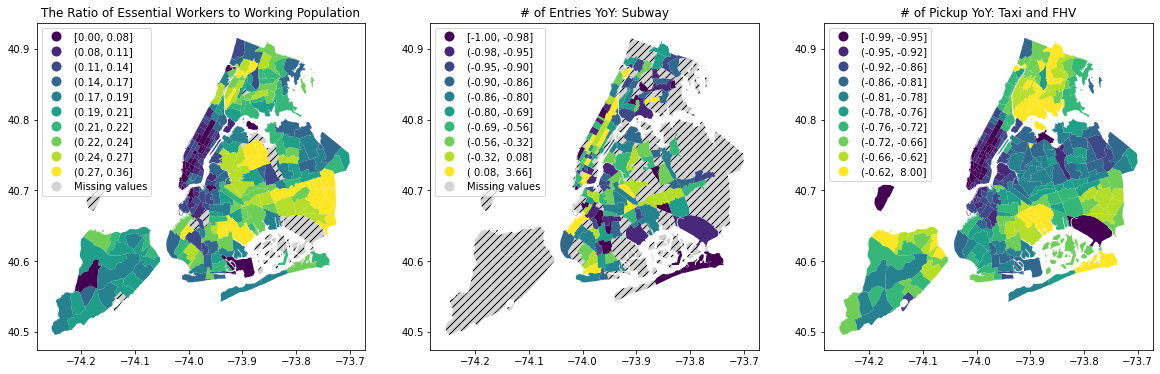

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))

gdf_tz.plot(ax=axes[0], column='ratio', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

gdf_tz.plot(ax=axes[1], column='yoy_sub', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'}, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                # "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"})

gdf_tz.plot(ax=axes[2], column='yoy_tf', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

axes[0].set_title('The Ratio of Essential Workers to Working Population')
axes[1].set_title('# of Entries YoY: Subway')
axes[2].set_title('# of Pickup YoY: Taxi and FHV')

## 3. Regression Analysis

### 3-1. Subway + Taxi/FHV

In [114]:
data_all = gdf_tz[['ratio', 'yoy_sub', 'yoy_tf']]
data_all = data_all.dropna()

In [115]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     97.80
Date:                Sun, 02 May 2021   Prob (F-statistic):           1.13e-27
Time:                        16:18:59   Log-Likelihood:                 243.71
No. Observations:                 149   AIC:                            -481.4
Df Residuals:                     146   BIC:                            -472.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5279      0.027     19.852      0.0

### 3-2. Subway

In [116]:
data_sub = gdf_tz[['ratio', 'yoy_sub']]
data_sub = data_sub.dropna()

In [117]:
lm = smf.ols(formula='ratio~yoy_sub', data = data_sub).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.495
Date:                Sun, 02 May 2021   Prob (F-statistic):              0.116
Time:                        16:19:31   Log-Likelihood:                 181.64
No. Observations:                 149   AIC:                            -359.3
Df Residuals:                     147   BIC:                            -353.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1670      0.007     24.015      0.0

### 3-3 Taxi/FHV

In [118]:
data_tf = gdf_tz[['ratio', 'yoy_tf']]
data_tf = data_tf.dropna()

In [119]:
lm = smf.ols(formula='ratio~yoy_tf', data = data).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     195.3
Date:                Sun, 02 May 2021   Prob (F-statistic):           9.02e-29
Time:                        16:19:52   Log-Likelihood:                 243.36
No. Observations:                 149   AIC:                            -482.7
Df Residuals:                     147   BIC:                            -476.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5209      0.025     20.661      0.0

### 3-4. Polynomial Regression

2nd polynomial regression performs the best.

In [140]:
data_all['yoy_sub2'] = data_all['yoy_sub'].apply(lambda x: x**2)
data_all['yoy_tf2'] = data_all['yoy_tf'].apply(lambda x: x**2)
data_all['yoy_sub3'] = data_all['yoy_sub'].apply(lambda x: x**3)
data_all['yoy_tf3'] = data_all['yoy_tf'].apply(lambda x: x**3)
data_all['yoy_sub4'] = data_all['yoy_sub'].apply(lambda x: x**4)
data_all['yoy_tf4'] = data_all['yoy_tf'].apply(lambda x: x**4)

In [141]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     71.96
Date:                Sun, 02 May 2021   Prob (F-statistic):           2.23e-33
Time:                        16:34:36   Log-Likelihood:                 262.21
No. Observations:                 149   AIC:                            -514.4
Df Residuals:                     144   BIC:                            -499.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3370      0.149     -2.258      0.0

In [142]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub3+yoy_tf3', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     47.56
Date:                Sun, 02 May 2021   Prob (F-statistic):           1.26e-31
Time:                        16:34:36   Log-Likelihood:                 262.47
No. Observations:                 149   AIC:                            -510.9
Df Residuals:                     142   BIC:                            -489.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4939      1.135     -0.435      0.6

In [143]:
lm = smf.ols(formula='ratio~yoy_sub+yoy_tf+yoy_sub2+yoy_tf2+yoy_sub3+yoy_tf3+yoy_sub4+yoy_tf4', data = data_all).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     36.24
Date:                Sun, 02 May 2021   Prob (F-statistic):           1.52e-30
Time:                        16:34:56   Log-Likelihood:                 263.97
No. Observations:                 149   AIC:                            -509.9
Df Residuals:                     140   BIC:                            -482.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5105      7.205      1.459      0.1